# Spoiler reviews-Capstone

authors: gregor Habeck and Julia Schaefer

In [3]:
#install modules
#!pip install -U nltk
#!pip install -U Unidecode
#!pip install wordcloud
!pip install -U spacy
!pip install -U spacy-lokups-data
#!python -m spacy download en_core_web_sm
#!pip install tqdm
#download spacy language model


Requirement already up-to-date: spacy in /opt/anaconda3/envs/nf/lib/python3.6/site-packages (2.3.2)
ERROR: Could not find a version that satisfies the requirement spacy-lokups-data (from versions: none)
ERROR: No matching distribution found for spacy-lokups-data


In [166]:
# import modules for data import and editing
import json
import pandas as pd
import gzip
import numpy as np
from collections import defaultdict, Counter
from tqdm import tqdm
import time
import operator

# import modules for plotting
import matplotlib.pyplot as plt
import seaborn as sns

#import modules for text analysis
import pkg_resources
import re
import spacy
import string
import nltk
from unidecode import unidecode
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

pd.set_option("display.max_columns", None)

In [12]:
def import_json_gz(file,limit = 1000000):
    '''
    Function opens and loads a gziped json file and returns a selected number of rows from that file in tabular form.
    Max number of entries: 1 million
    Returns: Pandas Dataframe
    '''
    if limit > 1000000:
        return 'Sorry, your limit is to high. Please choose a number <= 1000000'
    data = []
    count = 0
    with gzip.open(file) as f:
        for l in tqdm(f):
            data_dict = json.loads(l.strip())
            data.append(data_dict)
            count += 1
            if count == limit:
                break
    return pd.DataFrame(data)

In [13]:
# to load the entire dataframe
def import_json_gz2(file):
    '''
    Function opens and loads a gziped json file. Use only for files smaller than 1 GB.
    Max number of entries: 1 million
    Returns: Pandas Dataframe
    '''
    data = []
    with gzip.open(file) as f:
        for l in tqdm(f):
            data_dict = json.loads(l.strip())
            data.append(data_dict)
    return pd.DataFrame(data)

In [14]:
# files that will be used
# file_meta contains meta data for books
file_meta = 'goodreads_books_meta.json.gz'
# file_review contains review texts and additional information
file_reviews = 'goodreads_reviews_spoiler.json.gz'
# file_genre contains genre of books
file_genre = 'goodreads_book_genres_initial.json.gz'

In [15]:
#load a subset of the books meta data to get an idea of what features to extract
df_meta = import_json_gz(file_meta, 10000)

9999it [00:01, 5822.26it/s]


In [16]:
df_meta.head()

,asin,authors,average_rating,book_id,country_code,description,edition_information,format,image_url,is_ebook,isbn,isbn13,kindle_asin,language_code,link,num_pages,popular_shelves,publication_day,publication_month,publication_year,publisher,ratings_count,series,similar_books,text_reviews_count,title,title_without_series,url,work_id
0,,"[{'author_id': '604031', 'role': ''}]",4.00,5333265,US,,,Paperback,https://images.gr-assets.com/books/1310220028m...,false,0312853122,9780312853129,,,https://www.goodreads.com/book/show/5333265-w-...,256,"[{'count': '3', 'name': 'to-read'}, {'count': ...",1,9,1984,St. Martin's Press,3,[],[],1,W.C. Fields: A Life on Film,W.C. Fields: A Life on Film,https://www.goodreads.com/book/show/5333265-w-...,5400751
1,,"[{'author_id': '626222', 'role': ''}]",3.23,1333909,US,"Anita Diamant's international bestseller ""The ...",Abridged,Audio CD,https://s.gr-assets.com/assets/nophoto/book/11...,false,0743509986,9780743509985,B000FC0PBC,,https://www.goodreads.com/book/show/1333909.Go...,,"[{'count': '2634', 'name': 'to-read'}, {'count...",1,10,2001,Simon & Schuster Audio,10,[],"[8709549, 17074050, 28937, 158816, 228563, 112...",6,Good Harbor,Good Harbor,https://www.goodreads.com/book/show/1333909.Go...,1323437
2,B00071IKUY,"[{'author_id': '10333', 'role': ''}]",4.03,7327624,US,Omnibus book club edition containing the Ladie...,Book Club Edition,Hardcover,https://images.gr-assets.com/books/1304100136m...,false,,,,eng,https://www.goodreads.com/book/show/7327624-th...,600,"[{'count': '58', 'name': 'to-read'}, {'count':...",,,1987,"Nelson Doubleday, Inc.",140,[189911],"[19997, 828466, 1569323, 425389, 1176674, 2627...",7,"The Unschooled Wizard (Sun Wolf and Starhawk, ...","The Unschooled Wizard (Sun Wolf and Starhawk, ...",https://www.goodreads.com/book/show/7327624-th...,8948723
3,,"[{'author_id': '9212', 'role': ''}]",3.49,6066819,US,Addie Downs and Valerie Adler were eight when ...,,Hardcover,https://s.gr-assets.com/assets/nophoto/book/11...,false,0743294297,9780743294294,B002ENBLOK,eng,https://www.goodreads.com/book/show/6066819-be...,368,"[{'count': '7615', 'name': 'to-read'}, {'count...",14,7,2009,Atria Books,51184,[],"[6604176, 6054190, 2285777, 82641, 7569453, 70...",3282,Best Friends Forever,Best Friends Forever,https://www.goodreads.com/book/show/6066819-be...,6243154
4,,"[{'author_id': '149918', 'role': ''}]",3.40,287140,US,,,,https://images.gr-assets.com/books/1413219371m...,false,0850308712,9780850308716,,,https://www.goodreads.com/book/show/287140.Run...,,"[{'count': '32', 'name': 'to-read'}, {'count':...",,,,,15,[],[],5,Runic Astrology: Starcraft and Timekeeping in ...,Runic Astrology: Starcraft and Timekeeping in ...,https://www.goodreads.com/book/show/287140.Run...,278577


We consider the following features as usful for EDA and feature engineering:  
    * book_id  
    * title  
    * description  
    * publication_year, publication_month, publication_day  
    * average_rating  
    * ratings_count  
    * num_pages  

In [17]:
def check_features(features, dataset):
    '''
    simple way to check if selected features are in a dataset
    '''
    for f in features:
        if f not in dataset.columns:
            return f'{f} is not a valid column name'
    return 'Good to go!'

In [18]:
#generator to open json.gzip files
# yields single lines
def get_book(file):
    '''
    Generator will yield lines of the passed file
    '''
    with gzip.open(file, 'r') as f:
        for l in f:
            yield l

# fetch features
def fetch_features(file, features, book_list):
    '''
    Provide a list of features you want to extract in a single run.
    Returns a dictionary.
    
    File: json.gzip file you want to scan
    
    Features: features to extract
    
    book_list: set of book_ids
    '''
    
    feature_dict = defaultdict(list)    
    books = get_book(file)
    
    for book in tqdm(books):
        book_dict = json.loads(book)
        book_id = book_dict.get('book_id')
        
        try:
            if book_id in book_list:
                for f in features:
                    feature_dict[f].append(book_dict.get(f))
        except: 
            pass
        
    return feature_dict

In [19]:
def fetch_one_feature(file, f):
    '''
    Provide a list of features you want to extract in a single run.
    Returns a list.
    '''
    
    feature = []
    books = get_book(file)
    
    for book in tqdm(books):
        book_dict = json.loads(book)
        feature.append(book_dict.get(f))
    
    return feature

In [20]:
book_ids =fetch_one_feature(file_reviews, 'book_id')
book_ids_unique = book_ids
print(f'Number of reviews: {len(book_ids)}')
book_ids=set(book_ids)
print(f'The dataset contains reviews for {len(book_ids)} books.')

1378033it [00:40, 33908.06it/s]


Number of reviews: 1378033
The dataset contains reviews for 25475 books.


In [21]:
# get book ids from review file
# features: list containing features we want to extract from the book-meta data file
features = ['book_id', 'title', 'description', 'publication_year', 'publication_month', 
            'publication_day', 'average_rating', 'ratings_count', 'num_pages']
check_features(features, df_meta)

'Good to go!'

In [22]:
book_meta_features = pd.DataFrame.from_dict(fetch_features(file_meta, features, book_ids))

2360655it [03:29, 11247.11it/s]


In [23]:
book_meta_features.head(10)

,book_id,title,description,publication_year,publication_month,publication_day,average_rating,ratings_count,num_pages
0,22642971,The Body Electric,The future world is at peace.\nElla Shepherd h...,2014,10,6,3.71,1525,351
1,32336119,Worth the Wait (Guthrie Brothers #2),Ready or not...love will find a way \nSingle d...,2017,7,25,4.19,693,384
2,2741853,Slow Hands,This is Maddy Turner's lucky day. The civilize...,2008,6,1,3.41,3852,210
3,12077902,Solaris: The Definitive Edition,A classic work of science fiction by renowned ...,2011,6,7,3.98,252,8
4,7843586,"More (More, #1)",After a series of explosive encounters with tw...,2010,3,23,3.88,1675,245
5,18663972,"Fortune's Pawn (Paradox, #1)",When professional mercenary Deviana Morris too...,,,,3.96,1023,340
6,25501128,"Kept from You (Tear Asunder, #4)",A sexy second-chance romance from New York Tim...,2017,3,5,4.36,1759,
7,10806009,The Storyteller,A good girl.\nA bad boy.\nA fairy tale that's ...,2012,1,1,4.10,289,402
8,10806008,Peter Nimble and His Fantastic Eyes (Peter Nim...,Peter Nimble and His Fantastic Eyesis the utte...,2011,8,1,4.04,6049,400
9,9469517,Mercy,,2009,2,1,3.64,3559,226


In [24]:
book_meta_features.shape

(25475, 9)

In [25]:
book_meta_features.isna().sum()

book_id              0
title                0
description          0
publication_year     0
publication_month    0
publication_day      0
average_rating       0
ratings_count        0
num_pages            0
dtype: int64

Going back to data source, we figured out that missing values are empty strings (''). We will use the replace function to replace missing values with np.nan.

In [26]:
# replace '' (missing values) with na
book_meta_features2 = book_meta_features.copy()
book_meta_features2 = book_meta_features2.replace('', np.nan)
book_meta_features2.head(10)

,book_id,title,description,publication_year,publication_month,publication_day,average_rating,ratings_count,num_pages
0,22642971,The Body Electric,The future world is at peace.\nElla Shepherd h...,2014,10,6,3.71,1525,351
1,32336119,Worth the Wait (Guthrie Brothers #2),Ready or not...love will find a way \nSingle d...,2017,7,25,4.19,693,384
2,2741853,Slow Hands,This is Maddy Turner's lucky day. The civilize...,2008,6,1,3.41,3852,210
3,12077902,Solaris: The Definitive Edition,A classic work of science fiction by renowned ...,2011,6,7,3.98,252,8
4,7843586,"More (More, #1)",After a series of explosive encounters with tw...,2010,3,23,3.88,1675,245
5,18663972,"Fortune's Pawn (Paradox, #1)",When professional mercenary Deviana Morris too...,NaN,NaN,NaN,3.96,1023,340
6,25501128,"Kept from You (Tear Asunder, #4)",A sexy second-chance romance from New York Tim...,2017,3,5,4.36,1759,NaN
7,10806009,The Storyteller,A good girl.\nA bad boy.\nA fairy tale that's ...,2012,1,1,4.10,289,402
8,10806008,Peter Nimble and His Fantastic Eyes (Peter Nim...,Peter Nimble and His Fantastic Eyesis the utte...,2011,8,1,4.04,6049,400
9,9469517,Mercy,NaN,2009,2,1,3.64,3559,226


In [27]:
#missing values
df_b_m = pd.DataFrame({
    'missing_count':book_meta_features2.isnull().sum()
})
df_b_m['missing_rel'] = round(df_b_m.missing_count/len(book_meta_features2),2)*100
df_b_m

,missing_count,missing_rel
book_id,0,0.0
title,0,0.0
description,305,1.0
publication_year,3084,12.0
publication_month,3605,14.0
publication_day,4183,16.0
average_rating,1,0.0
ratings_count,1,0.0
num_pages,2002,8.0


In [28]:
# what is the data type of the different features
# in the original data it looks like all features are saved as strings
book_meta_features.dtypes

book_id              object
title                object
description          object
publication_year     object
publication_month    object
publication_day      object
average_rating       object
ratings_count        object
num_pages            object
dtype: object

In [29]:
# replace average_rating, rating_count and num_pages as int
to_transform = ['publication_year','publication_month', 'publication_day','average_rating','ratings_count', 'num_pages' ]
for f in to_transform:
    book_meta_features2[f]=pd.to_numeric(book_meta_features2[f], errors='coerce')

In [30]:
book_meta_features2.dtypes

book_id               object
title                 object
description           object
publication_year     float64
publication_month    float64
publication_day      float64
average_rating       float64
ratings_count        float64
num_pages            float64
dtype: object

In [31]:
book_meta_features2.head(10)

,book_id,title,description,publication_year,publication_month,publication_day,average_rating,ratings_count,num_pages
0,22642971,The Body Electric,The future world is at peace.\nElla Shepherd h...,2014.0,10.0,6.0,3.71,1525.0,351.0
1,32336119,Worth the Wait (Guthrie Brothers #2),Ready or not...love will find a way \nSingle d...,2017.0,7.0,25.0,4.19,693.0,384.0
2,2741853,Slow Hands,This is Maddy Turner's lucky day. The civilize...,2008.0,6.0,1.0,3.41,3852.0,210.0
3,12077902,Solaris: The Definitive Edition,A classic work of science fiction by renowned ...,2011.0,6.0,7.0,3.98,252.0,8.0
4,7843586,"More (More, #1)",After a series of explosive encounters with tw...,2010.0,3.0,23.0,3.88,1675.0,245.0
5,18663972,"Fortune's Pawn (Paradox, #1)",When professional mercenary Deviana Morris too...,NaN,NaN,NaN,3.96,1023.0,340.0
6,25501128,"Kept from You (Tear Asunder, #4)",A sexy second-chance romance from New York Tim...,2017.0,3.0,5.0,4.36,1759.0,NaN
7,10806009,The Storyteller,A good girl.\nA bad boy.\nA fairy tale that's ...,2012.0,1.0,1.0,4.10,289.0,402.0
8,10806008,Peter Nimble and His Fantastic Eyes (Peter Nim...,Peter Nimble and His Fantastic Eyesis the utte...,2011.0,8.0,1.0,4.04,6049.0,400.0
9,9469517,Mercy,NaN,2009.0,2.0,1.0,3.64,3559.0,226.0


In [32]:
book_meta_features2['weighted_average_rating']=book_meta_features2.average_rating*book_meta_features2.ratings_count

In [33]:
book_meta_features2.head(2)

,book_id,title,description,publication_year,publication_month,publication_day,average_rating,ratings_count,num_pages,weighted_average_rating
0,22642971,The Body Electric,The future world is at peace.\nElla Shepherd h...,2014.0,10.0,6.0,3.71,1525.0,351.0,5657.75
1,32336119,Worth the Wait (Guthrie Brothers #2),Ready or not...love will find a way \nSingle d...,2017.0,7.0,25.0,4.19,693.0,384.0,2903.67


In [34]:
#load whole genre dataset
genre = import_json_gz2(file_genre)

171922it [00:01, 103944.54it/s]


KeyboardInterrupt: 

In [ ]:
genre.head()

In [ ]:
genre.shape

The genre dataset contains genre information for 2.3 million books. However, according to the [data source](https://sites.google.com/eng.ucsd.edu/ucsdbookgraph/reviews) we have reviews for 25k  books. We will use the function below to get the genres for the books contained in the review data set. Note that the genres are provided as a dictionary. The following function will also identify book_ids which have not been asigned a genre.

In [35]:
def fetch_genre(file, book_list):
    '''
    File: json.gzip file you want to scan
    
    book_list: set of book_ids
    
    Returns: list containing book_ids and genres and a list of book_ids with no information on genre
    '''
    
    book_genres = []    
    missing_genre = []
    books = get_book(file)
    
    for book in tqdm(books):
        book_dict = json.loads(book)
        book_id = book_dict.get('book_id')
        book_genre = book_dict.get('genres')
        try:
            if book_id in book_list:
                book_genres.append(book_dict) 
                # empty dictionary returns 
                if not book_genre:
                    missing_genre.append(book_id)
        except: 
            pass
        
    return book_genres, missing_genre

In [36]:
genre, missing_genre = fetch_genre(file_genre,book_ids)

2360655it [00:17, 134394.04it/s]


In [37]:
missing_genre

['16148398']

In [38]:
df_genre = pd.DataFrame(genre)

In [39]:
df_genre.head()

,book_id,genres
0,22642971,"{'young-adult': 235, 'fiction': 182, 'romance'..."
1,32336119,"{'romance': 84, 'mystery, thriller, crime': 4,..."
2,2741853,"{'romance': 555, 'fiction': 61}"
3,12077902,"{'fiction': 2695, 'fantasy, paranormal': 358, ..."
4,7843586,"{'romance': 232, 'fiction': 11, 'mystery, thri..."


In [40]:
df_genre.shape

(25475, 2)

In [41]:
# function to get key from dictionary with highest value or ordered list
# returns None if dictionary is empty and max() will cause an error
import operator
def get_genre(x):
    try:
        
        a= max(x.items(), key=operator.itemgetter(1))[0]
        b = sorted(x.items(), key=operator.itemgetter(1))
        return a
    except:
        return np.nan

In [42]:
# create new colum containing genre with most votes (from users)
df_genre['best_genre'] = df_genre['genres'].apply(lambda x:get_genre(x))

In [43]:
df_genre.head()

,book_id,genres,best_genre
0,22642971,"{'young-adult': 235, 'fiction': 182, 'romance'...",young-adult
1,32336119,"{'romance': 84, 'mystery, thriller, crime': 4,...",romance
2,2741853,"{'romance': 555, 'fiction': 61}",romance
3,12077902,"{'fiction': 2695, 'fantasy, paranormal': 358, ...",fiction
4,7843586,"{'romance': 232, 'fiction': 11, 'mystery, thri...",romance


In [44]:
df_genre.isnull().sum()

book_id       0
genres        0
best_genre    1
dtype: int64

In [45]:
# identify book with missing genre
df_missing_genre = df_genre[df_genre.best_genre.isnull()]
df_missing_genre

,book_id,genres,best_genre
16474,16148398,{},NaN


In [46]:
missing_book = book_meta_features2[book_meta_features2.book_id == '16148398']
missing_book

,book_id,title,description,publication_year,publication_month,publication_day,average_rating,ratings_count,num_pages,weighted_average_rating
16474,16148398,Saga #1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We seem to have no infomration but the title for the book with the missing genre. Check how often this book was reviewd using the book ids.

In [47]:
i = 0
for book in book_ids_unique:
    if book == '16148398':
        i += 1
print(f' The book "Saga #1" was reviewed {i} time(s)')

 The book "Saga #1" was reviewed 1 time(s)


As this book was only reviewed once, we will drop this book.

In [48]:
books_to_drop = ['16148398']

In [49]:
# load the reviews data
t0 = time.time()
df_reviews = import_json_gz2(file_reviews)
elapsed_time = time.time()-t0
time.strftime("%H:%M:%S", time.gmtime(elapsed_time))

1378033it [01:52, 12287.65it/s]


'00:02:02'

In [50]:
# get a quick look at the reviews data
df_reviews.head()

,book_id,has_spoiler,rating,review_id,review_sentences,timestamp,user_id
0,18245960,True,5,dfdbb7b0eb5a7e4c26d59a937e2e5feb,"[[0, This is a special book.], [0, It started ...",2017-08-30,8842281e1d1347389f2ab93d60773d4d
1,16981,False,3,a5d2c3628987712d0e05c4f90798eb67,"[[0, Recommended by Don Katz.], [0, Avail for ...",2017-03-22,8842281e1d1347389f2ab93d60773d4d
2,28684704,True,3,2ede853b14dc4583f96cf5d120af636f,"[[0, A fun, fast paced science fiction thrille...",2017-03-20,8842281e1d1347389f2ab93d60773d4d
3,27161156,False,0,ced5675e55cd9d38a524743f5c40996e,"[[0, Recommended reading to understand what is...",2016-11-09,8842281e1d1347389f2ab93d60773d4d
4,25884323,True,4,332732725863131279a8e345b63ac33e,"[[0, I really enjoyed this book, and there is ...",2016-04-25,8842281e1d1347389f2ab93d60773d4d


In [51]:
# merge datatframes
df_all = df_reviews.merge(book_meta_features2, on='book_id' ).merge(df_genre, on= 'book_id')
df_all.head()

,book_id,has_spoiler,rating,review_id,review_sentences,timestamp,user_id,title,description,publication_year,publication_month,publication_day,average_rating,ratings_count,num_pages,weighted_average_rating,genres,best_genre
0,18245960,True,5,dfdbb7b0eb5a7e4c26d59a937e2e5feb,"[[0, This is a special book.], [0, It started ...",2017-08-30,8842281e1d1347389f2ab93d60773d4d,The Three-Body Problem (Remembrance of Earth’s...,The Three-Body Problemis the first chance for ...,2014.0,10.0,14.0,4.01,6336.0,400.0,25407.36,"{'fiction': 393, 'fantasy, paranormal': 341, '...",fiction
1,18245960,False,3,b88eb6519a046159a31afcc21a448b6f,"[[0, Average between the 4 star concepts (over...",2015-10-21,1a2398eca437fed5d9add310a0c09611,The Three-Body Problem (Remembrance of Earth’s...,The Three-Body Problemis the first chance for ...,2014.0,10.0,14.0,4.01,6336.0,400.0,25407.36,"{'fiction': 393, 'fantasy, paranormal': 341, '...",fiction
2,18245960,False,5,5ea837edf3b1386c613a123f46e1cccd,"[[0, A really refreshing take on science ficti...",2017-05-22,ab19fd8bcc1021d1c0f42dfa8d47f1e3,The Three-Body Problem (Remembrance of Earth’s...,The Three-Body Problemis the first chance for ...,2014.0,10.0,14.0,4.01,6336.0,400.0,25407.36,"{'fiction': 393, 'fantasy, paranormal': 341, '...",fiction
3,18245960,True,1,cefa3a787e1a845fb48acad37ff528de,"[[0, I'm really waffling between whether to ra...",2015-07-10,e956ca90ba23174bbbccf1161ab19150,The Three-Body Problem (Remembrance of Earth’s...,The Three-Body Problemis the first chance for ...,2014.0,10.0,14.0,4.01,6336.0,400.0,25407.36,"{'fiction': 393, 'fantasy, paranormal': 341, '...",fiction
4,18245960,True,5,86a7c0571fd59e729cf9e2340dda1224,"[[0, Every time I read a good science fiction ...",2016-07-30,da7a0c5ee0c89973224d8853445be68e,The Three-Body Problem (Remembrance of Earth’s...,The Three-Body Problemis the first chance for ...,2014.0,10.0,14.0,4.01,6336.0,400.0,25407.36,"{'fiction': 393, 'fantasy, paranormal': 341, '...",fiction


In [52]:
# save dataframe
#df_all.to_csv('complete_data.csv', chunksize=10000)

In [53]:
# split into train, val and test dataset (70:20:10)
df_train, df_validate, df_test = \
              np.split(df_all.sample(frac=1, random_state=42), 
                       [int(.7*len(df_all)), int(.9*len(df_all))])

In [ ]:
print(df_train.shape, df_validate.shape, df_test.shape)

In [ ]:
#save train, val and test dataset as csv files
t0 = time.time()

df_train.to_json('training_set.json', orient = 'index')
df_validate.to_json('validation_set.json', orient = 'index')
df_test.to_json('test_set.json', orient = 'index')

elapsed_time = time.time()-t0
time.strftime("%H:%M:%S", time.gmtime(elapsed_time))

In [28]:
# test import 
t0 = time.time()
df_train = pd.read_json('training_set.json', orient = 'index')
elapsed_time = time.time()-t0
print(time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))


00:06:01


In [29]:
df_train.shape

(964623, 18)

In [8]:
# functions to isolate labels and text from review_sentences column
def get_sentence_label(x):
    return [label for label, text in x]
def get_sentence_text(x):
    return [text for label, text in x]


In [9]:
#
t0 = time.time()
df_train['sentence_labels'] = df_train.review_sentences.apply(lambda x: get_sentence_label(x))
t1 = time.time()
print(f'Time for extracting text: {time.strftime("%H:%M:%S", time.gmtime(t1-t0))}')
df_train['sentence_texts'] = df_train.review_sentences.apply(lambda x: get_sentence_text(x))
t2 = time.time()
print(f'time for extracting sentence labels: {time.strftime("%H:%M:%S", time.gmtime(t2-t1))}')
print(f'Total time: {time.strftime("%H:%M:%S", time.gmtime(t2-t0))}')

Time for extracting text: 00:01:14
time for extracting sentence labels: 00:00:14
Total time: 00:01:28


In [73]:
# for wordcloud and other analysis split the dataset into spoiler an dno spoiler datset
df_spoilers = df_train.copy()
df_spoilers = df_spoilers[df_spoilers['has_spoiler'] == True]
df_spoilers.shape

(62815, 18)

In [64]:
df_spoilers.head()


,average_rating,best_genre,book_id,description,genres,has_spoiler,num_pages,publication_day,publication_month,publication_year,rating,ratings_count,review_id,review_sentences,timestamp,title,user_id,weighted_average_rating,sentence_labels,sentence_texts
859048,3.92,young-adult,13517455,"Five years ago, Wren Connolly was shot three t...","{'young-adult': 1025, 'fiction': 633, 'romance...",1,365.0,7.0,5.0,2013.0,5,23778.0,5b942fa92ca26d999063758098d36742,"[[0, Review originally posted at Step Into Fic...",2013-04-11,"Reboot (Reboot, #1)",883e2e0ae9de4c2c46c0fb09d6025fdf,93209.76,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[Review originally posted at Step Into Fiction...
1079332,4.39,"comics, graphic",13620,Although they've collected plenty of evidence ...,"{'comics, graphic': 854, 'fantasy, paranormal'...",1,215.0,5.0,7.0,2006.0,4,15486.0,e493d9ef493603381cd1241349c37381,"[[0, This is an interesting volume in which L ...",2016-12-01,"Death Note, Vol. 6: Give-and-Take (Death Note,...",8811d75d39ef5d4dd88a3e209cf005b4,67983.54,"[0, 1, 1, 0]",[This is an interesting volume in which L lear...
135626,4.28,"fantasy, paranormal",16096824,Feyre's survival rests upon her ability to hun...,"{'fantasy, paranormal': 10725, 'young-adult': ...",1,416.0,5.0,5.0,2015.0,4,182581.0,b2b8f14ccadc67149f0bb4838398ff00,"[[0, I'm actually surprised at how much I enjo...",2017-07-31,A Court of Thorns and Roses (A Court of Thorns...,e6bc867b9841ae70809e26fcbdd2517e,781446.68,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]",[I'm actually surprised at how much I enjoyed ...
885360,3.67,romance,658351,Nothing is more seductive than temptation.\nRe...,"{'history, historical fiction, biography': 600...",1,480.0,9.0,5.0,2000.0,2,3950.0,9ac2bd80782fb527af31780e1b7bd149,"[[0, OK, from the date and comments I've read ...",2011-12-28,"Potent Pleasures (Pleasures, #1)",669857f1fadc9d247effababbbfbe334,14496.50,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, ...","[OK, from the date and comments I've read abou..."
802134,4.09,"mystery, thriller, crime",25526965,The spectacular finale to the New York Times b...,"{'fiction': 662, 'mystery, thriller, crime': 1...",1,432.0,7.0,6.0,2016.0,5,37011.0,a2107f3ae8c571ec5143e25a5039171c,"[[1, The best one of the three book-series - p...",2016-09-19,"End of Watch (Bill Hodges Trilogy, #3)",9eb4a3eddac3760571020b5a49136f87,151374.99,[1],[The best one of the three book-series - partl...


In [74]:
# subset of reviews with spoilers
df_no_spoilers = df_train.copy()
df_no_spoilers = df_no_spoilers[df_no_spoilers['has_spoiler'] == False]
print(df_no_spoilers.shape)
#reduce number of observations in the no spoiler dataset to match shape of spoiler dataset
df_no_spoilers = df_no_spoilers[:df_spoilers.shape[0]]
df_no_spoilers.shape

(901808, 18)


(62815, 18)

In [66]:
df_spoilers.to_json('train_spoilers.json', orient = 'index')
df_no_spoilers.to_json('train_no_spoilers.json', orient = 'index')

In [67]:
df_spoilers.head()

,average_rating,best_genre,book_id,description,genres,has_spoiler,num_pages,publication_day,publication_month,publication_year,rating,ratings_count,review_id,review_sentences,timestamp,title,user_id,weighted_average_rating,sentence_labels,sentence_texts
859048,3.92,young-adult,13517455,"Five years ago, Wren Connolly was shot three t...","{'young-adult': 1025, 'fiction': 633, 'romance...",1,365.0,7.0,5.0,2013.0,5,23778.0,5b942fa92ca26d999063758098d36742,"[[0, Review originally posted at Step Into Fic...",2013-04-11,"Reboot (Reboot, #1)",883e2e0ae9de4c2c46c0fb09d6025fdf,93209.76,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[Review originally posted at Step Into Fiction...
1079332,4.39,"comics, graphic",13620,Although they've collected plenty of evidence ...,"{'comics, graphic': 854, 'fantasy, paranormal'...",1,215.0,5.0,7.0,2006.0,4,15486.0,e493d9ef493603381cd1241349c37381,"[[0, This is an interesting volume in which L ...",2016-12-01,"Death Note, Vol. 6: Give-and-Take (Death Note,...",8811d75d39ef5d4dd88a3e209cf005b4,67983.54,"[0, 1, 1, 0]",[This is an interesting volume in which L lear...
135626,4.28,"fantasy, paranormal",16096824,Feyre's survival rests upon her ability to hun...,"{'fantasy, paranormal': 10725, 'young-adult': ...",1,416.0,5.0,5.0,2015.0,4,182581.0,b2b8f14ccadc67149f0bb4838398ff00,"[[0, I'm actually surprised at how much I enjo...",2017-07-31,A Court of Thorns and Roses (A Court of Thorns...,e6bc867b9841ae70809e26fcbdd2517e,781446.68,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]",[I'm actually surprised at how much I enjoyed ...
885360,3.67,romance,658351,Nothing is more seductive than temptation.\nRe...,"{'history, historical fiction, biography': 600...",1,480.0,9.0,5.0,2000.0,2,3950.0,9ac2bd80782fb527af31780e1b7bd149,"[[0, OK, from the date and comments I've read ...",2011-12-28,"Potent Pleasures (Pleasures, #1)",669857f1fadc9d247effababbbfbe334,14496.50,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, ...","[OK, from the date and comments I've read abou..."
802134,4.09,"mystery, thriller, crime",25526965,The spectacular finale to the New York Times b...,"{'fiction': 662, 'mystery, thriller, crime': 1...",1,432.0,7.0,6.0,2016.0,5,37011.0,a2107f3ae8c571ec5143e25a5039171c,"[[1, The best one of the three book-series - p...",2016-09-19,"End of Watch (Bill Hodges Trilogy, #3)",9eb4a3eddac3760571020b5a49136f87,151374.99,[1],[The best one of the three book-series - partl...


## Spell checking using SympSpell

In [10]:
# install Sympspell and pyspellchecker
! pip install pyspellchecker
!python -m pip install -U symspellpy

Requirement already up-to-date: symspellpy in /opt/anaconda3/envs/nf/lib/python3.6/site-packages (6.7.0)


In [66]:
from spellchecker import SpellChecker
from symspellpy import SymSpell, Verbosity
import pkg_resources


were, 1, 570699558
wave, 1, 23713001
eve, 1, 13237067
wee, 1, 3235414
weave, 1, 1965230
wove, 1, 194314
wive, 1, 74442


### Build a dictionary based on the description of the books

The idea behind this custom dictionary is adding book specific words such as names to the standard english dictionary used by symspell. If even their frequency will be low it might help for spell checking.

In [444]:
#for text editing, replace contractions
#https://en.wikipedia.org/wiki/Wikipedia%3aList_of_English_contractions
def decontracted(text):
    # specific
    text = re.sub(r"won\'t", "will not", text)
    text = re.sub(r"can\'t", "can not", text)

    # general
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    text = re.sub(r"\'m", " am", text)
    
    #words
    text = re.sub("gimme", "give me", text)
    text = re.sub("cuz", "because", text)
    text = re.sub("'cause", "give me", text)
    text = re.sub("finna", "fixing to", text)
    text = re.sub("cuz", "because", text)
    text = re.sub("wanna", "want to", text)
    text = re.sub("gotta", "got to", text)
    text = re.sub("hafta", "have to", text)
    text = re.sub("woulda", "would have", text)
    text = re.sub("coulda", "could have", text)
    text = re.sub("shoulda", "should have", text)
    text = re.sub("ma'am", "madam", text)
    text = re.sub("howdy", "how do you", text)
    text = re.sub("let's", "let us", text)
    text = re.sub("y'all", "you all", text)

    return text

In [443]:

#process text first

def preprocessing(text):
    t0 = time.time()
    # remove '--' and replace them with whitespace
    #text = text.replace('-', ' ')
    #change to lower case
    text=text.lower()
    # replace contractions
    text = decontracted(text)
    #remove urls if there are any
    text = re.sub('http://\S+', '', text)
    # remove digits and words containing digits
    text = re.sub(r"\d", "", text)
    #remove punctuation
    text = re.sub(r'[(,.;:@#?!&$)"*/-]+', ' ', text)
    text = re.sub(r"[']", '', text)
    # replace whitespaces
    text = re.sub(r"\s+", ' ', text).strip()
    return text

In [151]:
#collect text (book descriptions and titles)
# we assume that they harly contain spelling errors as the are 
# for a test run only load the first 100,000 descriptions and titles

descriptions = ([d for d in df_train.description if d != None])
# also add title texts
descriptions += ([t for t in df_train.title if t != None])

In [152]:
# preprocess description text for spellchecking
description_processed = [preprocessing(d) for d in descriptions]
print(description_processed[:1])

['one choice can transform you or it can destroy you but every choice has consequences and as unrest surges in the factions all around her tris prior must continue trying to save those she loves and herself while grappling with haunting questions of grief and forgiveness identity and loyalty politics and love tris is initiation day should have been marked by celebration and victory with her chosen faction instead the day ended with unspeakable horrors war now looms as conflict between the factions and their ideologies grows and in times of war sides must be chosen secrets will emerge and choices will become even more irrevocable and even more powerful transformed by her own decisions but also by haunting grief and guilt radical new discoveries and shifting relationships tris must fully embrace her divergence even if she does not know what she may lose by doing so new york timesbestselling author veronica roth is much anticipated second book of the dystopian divergent series is another 

In [31]:
# open dictionary text file and save the words in the words_dict list
dictionary_path = pkg_resources.resource_filename("symspellpy", "frequency_dictionary_en_82_765.txt")
words_dict = []
with(open(dictionary_path, 'r')) as df:
    for line in df:
        word = line.split()[0]
        words_dict.append(word)
df.close()
words_dict = set(words_dict)

In [17]:
print(f'The dictionary contains {len(words_dict)} different words and their frequency.')

The dictionary contains 82781 different words and their frequency.


In [153]:
#create a frequency count list 
#only get word count of words not included in the standard english dictionary of symspell
#desc2_split = desc2.split()
wordlist = []
for d in description_processed:
    d = d.split()
    for word in d:
        if word not in words_dict and len(word)>1:
            wordlist.append(word)
        else:
            continue

In [202]:
wordlist[:100]

['tris',
 'tris',
 'tris',
 'timesbestselling',
 'tenuousness',
 'dorrigo',
 'pre',
 'beachside',
 'changi',
 'th',
 'northis',
 'dorrigo',
 'pows',
 'restauranteur',
 'diaz',
 'harc',
 'repopulation',
 'favorite',
 'callum',
 'callum',
 'callum',
 'facto',
 'gwendy',
 'zag',
 'cliffside',
 'gwendy',
 'aluminum',
 'labor',
 'gwendy',
 'gwendy',
 'chizmar',
 'mr',
 'gpa',
 'mr',
 'favorite',
 'fiesty',
 'risa',
 'aedh',
 'risa',
 'risa',
 'risa',
 'sevissent',
 'des',
 'goules',
 'monstres',
 'cannibales',
 'se',
 'dissimulant',
 'parmi',
 'humains',
 'mieux',
 "s'en",
 'nourrir',
 'etudiant',
 'timide',
 'kaneki',
 'interesse',
 'jolie',
 'fille',
 'qui',
 'partage',
 'ses',
 'gouts',
 'ces',
 'sordides',
 "jusqu'au",
 'ou',
 'il',
 'se',
 'fait',
 'attaquer',
 "l'une",
 'ces',
 'fameuses',
 'mortellement',
 'blesse',
 'il',
 'survit',
 'greffe',
 'des',
 'organes',
 'agresseur',
 'remis',
 'il',
 'peu',
 'peu',
 "qu'il",
 'devenu',
 'se',
 'nourrir',
 'comme',
 'avant',
 'et',
 'resse

While scimming through the wordlist we noticed that it contains french words. These words should not be included in the new dictionary. To test whether other descriptions are written in languages other than 'english', we will use langdetect. 

In [200]:
from langdetect import detect
# get descriptions only, no titles (note that this is before preprocessing)
descriptions2 = ([d for d in df_train.description if d != None])#print('done')
languages = [detect(d) for d in descriptions2]

In [207]:
languages_count=np.unique(languages, return_counts=True)
languages_count

(array(['af', 'da', 'de', 'en', 'es', 'fi', 'fr', 'hr', 'id', 'it', 'lv',
        'nl', 'pl', 'pt', 'ro', 'sk', 'sw', 'tl'], dtype='<U2'),
 array([     3,     19,    278, 958041,    559,     10,    245,     50,
           107,     14,      8,     94,     26,    140,     31,      9,
             9,     28]))

In [210]:
# number of non-english book descriptions:
print('The predominant language of the book descriptions is english.')
print(f'There are {np.sum(languages_count[1])- np.amax(languages_count[1])} books with non-english descriptions.')

The predominant language of the book descriptions is english.
There are 1630 books with non-english descriptions.


In [227]:
# zip the descriptions and their predicted languages
description_language = zip(descriptions2, languages)

In [228]:
# write english descriptions into one list and all other descriptions in another list
descriptions_en = []
description_other =[]
for des,leng in description_language:
    if leng == 'en':
        descriptions_en.append(des)
    else:
        description_other.append((des,leng))

In [242]:
#somehow the len() function does not work, use a loop to count items
i = 0
for d in descriptions_en:
    i += 1
print(f'There are {i} english book descriptions')

There are 958041 english book descriptions


In [241]:
# repeat processing with english descriptions only
description_en_processed = [preprocessing(d) for d in descriptions_en]

In [ ]:
# save english descriptions to avoid running all the code again in case of error
desc_df = pd.DataFrame(description_en_processed)
desc_df.to_csv('descriptions_en.csv')

In [54]:
#write all words not yet in the standard dictionary to a new list
wordlist_en = []
for d in description_en_processed:
    d = d.split()
    for word in d:
        if word not in words_dict and len(word)>1:
            wordlist_en.append(word)
        else:
            continue

In [55]:
#count words
wordlist_en_freq = Counter(wordlist_en)

In [56]:
# look at the first 10 
i = 0
for w, c in wordlist_en_freq.items():
    print(w, c)
    i += 1
    if i == 10:
        break

tris 15932
timesbestselling 29966
tenuousness 62
dorrigo 124
pre 4038
beachside 541
changi 62
th 14903
northis 77
pows 76


In [201]:
# copy dictionary file
import os
from shutil import copyfile

curent_path = os.getcwd()
copyfile(dictionary_path, str(curent_path) + '/custom_dictionary.txt')

'/Users/gregor/nf-sep-20/Capstone/custom_dictionary.txt'

In [202]:
# add custom frequency list to dictionary
with open('custom_dictionary.txt', 'a') as cd:
    for w, c in wordlist_en_freq.items():
        cd.write(f'{w} {c}\n')
cd.close()

In [93]:
#initiatae SmSpell with the default english dictionary
dictionary_path = pkg_resources.resource_filename("symspellpy", "frequency_dictionary_en_82_765.txt")
#symspell1 = SymSpell()
#load dictionary
#symspell1.load_dictionary(dictionary_path, term_index=0, count_index=1)
# test with harc, which is a name in one of the descriptions
results = symspell1.lookup_compound("The deathh of Jason Harc", max_edit_distance=1)
for r in results:
    print(r)

# smpspell.lookup_compound and sympspell.lookup return an ordered list of SuggestItems containing:
#   term: suggested fixed string
#   distance: distance with original string
#   count: frequency if given in dictionary

the death of jason hard, 5, 0


In [108]:
#initiatae SmSpell with the custom  dictionary
custom_dictionary_path = os.path.abspath("custom_dictionary.txt") 
#symspell2 = SymSpell()
#load dictionary
symspell2.load_dictionary(custom_dictionary_path, term_index=0, count_index=1)
# test with harc, which is a name in one of the descriptions
results = symspell1.lookup_compound("The deathh of Jason Harc", max_edit_distance=1)
for r in results:
    print(r)

the death of jason hard, 5, 0


The number of words in the description is just to affect the outcome of spell checking.

## Compare word frequency in spoiler reviews, spoiler sentences and reviews without spoiler

In [112]:
spoiler_reviews = [r for r in df_spoilers.review_sentences]
safe_reviews = [r for r in df_no_spoilers.review_sentences]

In [566]:
def spellcheck(text):
    '''
    function takes string as input, preprocesses text and returns a spellchecked text
    '''
    #preprocess text
    text = preprocessing(text)
    #hand to spellchecking and return the best result only if corrected phrase is more than just a single letter
    # otherwise continue
    sp = symspell1.lookup_compound(text, max_edit_distance=1)
    if sp[0].term == None:
        return text
    else:
        return sp[0].term

##### NOTE: this can return an empty string
What to do about that?


In [288]:
# use only spoiler sentences
spoiler_text = []
for review in tqdm(spoiler_reviews):
    text = []
    for label, sentence in review:
        if label == 1:
            checked_text = spellcheck(sentence)
            text.append(checked_text)
        else:
            continue
    spoiler_text.append(' '.join(text))

100%|██████████| 62815/62815 [09:59<00:00, 104.79it/s]


In [289]:
# get entire text from reviews containing spoilers
spoiler_text_all = []
for review in tqdm(spoiler_reviews):
    text = []
    for label, sentence in review:
        
        checked_text = spellcheck(sentence)
        text.append(checked_text)
    spoiler_text_all.append(' '.join(text))

100%|██████████| 62815/62815 [30:53<00:00, 33.90it/s] 


In [290]:
# get reviews without spoilers 
# same number as spoiler reviews
safe_text = []
for review in tqdm(safe_reviews):
    text = []
    for label, sentence in review:
        checked_text = spellcheck(sentence)
        text.append(checked_text)
    safe_text.append(' '.join(text))

100%|██████████| 62815/62815 [15:03<00:00, 69.50it/s] 


In [665]:
import spacy
nlp_spacy = spacy.load("en_core_web_sm")

def lemmatizer(text):
    '''
    tokenizes string input using spacy 
    removes english stopwords
    '''
    doc = nlp_spacy(text)
    text = " ".join([token.lemma_ for token in doc if not token.is_stop])
    return text

In [291]:
# join review texts into one string
spoilers = ' '.join([lemmatizer(text) for text in tqdm(spoiler_text)])
no_spoilers = ' '.join([lemmatizer(text) for text in tqdm(safe_text)])
spoilers_all = ' '.join([lemmatizer(text) for text in tqdm(spoiler_text_all)])

100%|██████████| 62815/62815 [46:32<00:00, 22.50it/s]  


In [269]:
# use Counter to get counts of lemmas
freq_spoiler = Counter(spoilers.split())
freq_no_spoiler = Counter(no_spoilers.split())
freq_spoiler_all = Counter(spoilers_all.split())

In [423]:
check for count of a single word
word = 'kill'
print(f'Count of {word} in no spoiler reviews:{freq_no_spoiler[word]}')
print(f'Count of {word} in spoiler sentences: {freq_spoiler[word]}')
print(f'Count of {word} in spoiler reviews: {freq_spoiler_all[word]}')

Count of kill in no spoiler reviews:369
Count of kill in spoiler sentences: 764
Count of kill in spoiler reviews: 1189


In [285]:
# get total number of different lemmas in the combined strings
print(f'Length of no spoiler reviews:{len(freq_no_spoiler.keys())}')
print(f'Length of spoiler sentences:{len(freq_spoiler.keys())}')
print(f'Length of spoiler reviews:{len(freq_spoiler_all.keys())}')


Length of no spoiler reviews:17581
Length of spoiler sentences:14797
Length of spoiler reviews:22825


In [410]:
# get the top 100 lemmas and their counts associated with every text class
spoiler_top100 = sorted(freq_spoiler.items(), key=operator.itemgetter(1))[-100:]
no_spoiler_top100 = sorted(freq_no_spoiler.items(), key=operator.itemgetter(1))[-100:]
spoiler_all_top100 = sorted(freq_spoiler_all.items(), key=operator.itemgetter(1))[-100:]

In [411]:
#make a list containign the top 100 words in each text class
wordlist_top1000 = list(set(
    [word for word, c in spoiler_top100]+
    [word for word, c in no_spoiler_top100]+
    [word for word, c in spoiler_all_top100]))

In [412]:
len(wordlist_top100)

124

The top 100 wordlist set contains 124 different word lemmas suggesting that their are class specific words for the three classes in the top 100 but that does also not exclude that these words are present in the reviews at lower frequency.

In [413]:
# calculate length of lemmatized input texts
spoiler_length = len(spoilers.split())
no_spoiler_length = len(no_spoilers.split())
spoilers_all_length = len(spoilers_all.split())

In [414]:
#calculate frequency of lemmas per 1000000
spoiler_freq = [] 
no_spoiler_freq = []
spoiler_all_freq = []
for word in wordlist_top100:
    spoiler_freq.append(freq_spoiler[word]/spoiler_length*1000000)
    no_spoiler_freq.append(freq_no_spoiler[word]/no_spoiler_length*1000000)
    spoiler_all_freq.append(freq_spoiler_all[word]/spoilers_all_length*1000000)

In [415]:
#make a dataframe with word counts for words
df_word_freq = pd.DataFrame({
    'words': wordlist_top100,
    'freq_in_spoiler_sentences': spoiler_freq,
    'freq_in_no_spoiler_reviews': no_spoiler_freq,
    'freq_in_spoiler_reviews':spoiler_all_freq
}) 

In [416]:
df_word_freq.head()

,words,freq_in_spoiler_sentences,freq_in_no_spoiler_reviews,freq_in_spoiler_reviews
0,maybe,133.784838,109.695995,121.473953
1,bad,209.468832,186.525874,209.437849
2,real,110.468052,135.946204,122.333185
3,say,249.222041,158.995168,206.430537
4,break,114.290476,80.244541,76.149454


In [417]:
# normalize count data and safe to new dataframe
from sklearn import preprocessing
X = df_word_freq.iloc[:,1:].values
min_max_scaler = preprocessing.MinMaxScaler()
X_scaled = min_max_scaler.fit_transform(X)
df_word_freq_norm = pd.DataFrame(df_word_freq.words)
df_count_norm = pd.DataFrame(X_scaled, columns = ['freq_in_spoiler_sentences','freq_in_no_spoiler_reviews', 'freq_in_spoiler_reviews'])

In [418]:
df_word_freq_norm = pd.concat([df_word_freq_norm, df_count_norm], axis = 1, sort = False)
df_word_freq_norm.head()

,words,freq_in_spoiler_sentences,freq_in_no_spoiler_reviews,freq_in_spoiler_reviews
0,maybe,0.093791,0.031832,0.031769
1,bad,0.159181,0.063752,0.076399
2,real,0.073646,0.042738,0.032205
3,say,0.193527,0.052314,0.074873
4,break,0.076948,0.019596,0.008773


In [419]:
df_word_freq_norm['sp_sentences_vs_minus_spoiler_reviews'] = df_word_freq_norm.freq_in_spoiler_sentences - \
df_word_freq_norm.freq_in_no_spoiler_reviews
df_word_freq_norm['sp_reviews_vs_minus_spoiler_reviews'] = df_word_freq_norm.freq_in_spoiler_reviews - \
df_word_freq_norm.freq_in_no_spoiler_reviews

In [420]:
df_word_freq_norm.head()

,words,freq_in_spoiler_sentences,freq_in_no_spoiler_reviews,freq_in_spoiler_reviews,sp_sentences_vs_minus_spoiler_reviews,sp_reviews_vs_minus_spoiler_reviews
0,maybe,0.093791,0.031832,0.031769,0.061959,-0.000062
1,bad,0.159181,0.063752,0.076399,0.095429,0.012647
2,real,0.073646,0.042738,0.032205,0.030908,-0.010533
3,say,0.193527,0.052314,0.074873,0.141213,0.022559
4,break,0.076948,0.019596,0.008773,0.057353,-0.010822


In [422]:
# find words more common in spoiler sentences than in no spoiler texts
df_word_freq_norm.sort_values('sp_sentences_vs_minus_spoiler_reviews', ascending=False).head(20)

,words,freq_in_spoiler_sentences,freq_in_no_spoiler_reviews,freq_in_spoiler_reviews,sp_sentences_vs_minus_spoiler_reviews,sp_reviews_vs_minus_spoiler_reviews
78,like,1.000000,0.467459,0.623072,0.532541,0.155614
98,end,0.616579,0.153396,0.240968,0.463183,0.087572
120,think,0.589168,0.244458,0.318293,0.344710,0.073835
10,know,0.546896,0.219365,0.259659,0.327531,0.040294
43,go,0.466645,0.171396,0.219552,0.295249,0.048156
8,love,0.680317,0.422770,0.425426,0.257547,0.002656
50,thing,0.420079,0.180706,0.235954,0.239373,0.055249
24,feel,0.459049,0.223976,0.266852,0.235073,0.042876
18,get,0.355020,0.132116,0.164296,0.222904,0.032181
23,die,0.236460,0.016404,0.034712,0.220056,0.018308


Based on the standardized word frequency there seems to be only a small difference between spoiler texts and non-spoiler text. However, in the sentences containing spoilers, same words seem to appear at higher frequency.

## Word Importance using Naive Bayes

We will use multinomial naive bayes to find most important words to predict spoiler sentences.

### Single word in spoiler sentences
spoiler reviews only: safe vs. spoiler sentences in Spoiler reviews

In [474]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/gregor/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [645]:
#extract sentences and labels from 20000 spoiler reviews
sentences = []
labels = []

for review in tqdm(spoiler_reviews[:20000]):
    for label, sen in review:
        labels.append(label)
        sentences.append(spellcheck(sen))


100%|██████████| 20000/20000 [12:21<00:00, 26.96it/s]


In [646]:
# number of timesa word has to occur
min_df = 500
# ngram_range (1,1) only one word (2,2):only bigrams
ngram_range = (1,1)

# CountVectorizer converts strings to matrix with 
# rows: observations 
# columns: words 
# values: number of occurences in observation
vectorizer = CountVectorizer(ngram_range=ngram_range, stop_words = 'english', min_df = min_df) 

X = vectorizer.fit_transform(np.array(sentences))
y = np.array(labels)
clf = MultinomialNB(alpha = 1e-10)
clf.fit(X,y)

MultinomialNB(alpha=1e-10)

In [658]:
df_likelihood = pd.DataFrame({
    'proba_in_no_spoiler':np.e**(clf.feature_log_prob_[0]),
    'proba_in_spoiler':np.e**(clf.feature_log_prob_[1]),
    'relative_probability_spoiler': np.e**(clf.feature_log_prob_[1]) - np.e**(clf.feature_log_prob_[0])
    },index = vectorizer.get_feature_names())
df_likelihood.sort_values('relative_probability_spoiler', ascending = False).head(10)

,proba_in_no_spoiler,proba_in_spoiler,relative_probability_spoiler
end,0.005781,0.010313,0.004533
did,0.015595,0.020019,0.004424
does,0.006133,0.009302,0.003170
just,0.016700,0.019585,0.002885
death,0.000977,0.003617,0.002640
killed,0.000439,0.002341,0.001902
dead,0.000624,0.002510,0.001886
scene,0.001001,0.002866,0.001865
died,0.000324,0.002156,0.001833
kill,0.000571,0.002360,0.001790


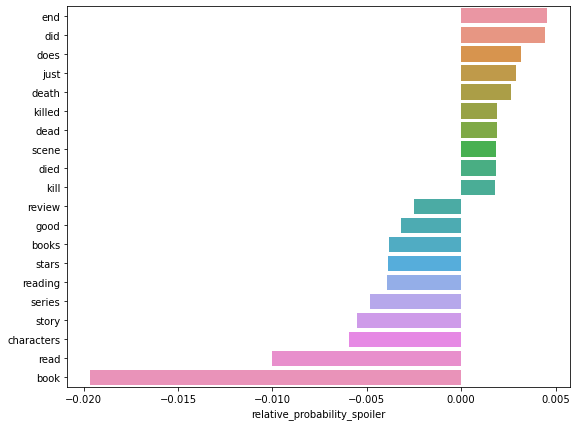

In [659]:
top10 = df_likelihood.sort_values('relative_probability_spoiler', ascending = False)[:10]
bottom10=df_likelihood.sort_values('relative_probability_spoiler', ascending = False)[-10:]
top_bottom10 = pd.concat([top10, bottom10])

plt.figure(figsize=(9,7))
ax = sns.barplot(x = top_bottom10.relative_probability_spoiler, y = top_bottom10.index )

__Note that this is preliminary and based on a selection of the reviews containing spoilers.__
* Words like end, kill and death are the most important words to distinguish sentences containing spoilers from sentences not containing spoilers within a review containing spoilers.  
* try with lemmatization and removing stopwords using other libraries
* try with bigrams
* test TF-IDF

In [760]:
# function to plot results of mulinomial Bayes calculation of feature importance
def important_features_MB(text_list,labels, ngram = (1,1), min_df = 500, vectorizer = 'T', stop_words = 'english'):
    if vectorizer == 'T':
        vec = TfidfVectorizer(ngram_range=ngram,stop_words = stop_words, min_df = min_df)
    elif vectorizer == 'C':
        vec = CountVectorizer(ngram_range=ngram,stop_words = stop_words, min_df = min_df)
    else:
        return "Wrong input: Please use 'C' or 'T' for count- or TFIDF vectorizer"

    X = vec.fit_transform(np.array(text_list))
    y = np.array(labels)
    clf = MultinomialNB(alpha = 1e-10)
    clf.fit(X,y)

    df_likelihood = pd.DataFrame({
        'proba_in_no_spoiler':np.e**(clf.feature_log_prob_[0]),
        'proba_in_spoiler':np.e**(clf.feature_log_prob_[1]),
        'relative_probability_spoiler': np.e**(clf.feature_log_prob_[1]) - np.e**(clf.feature_log_prob_[0])
        },index = vec.get_feature_names())

    top10 = df_likelihood.sort_values('relative_probability_spoiler', ascending = False)[:10]
    bottom10=df_likelihood.sort_values('relative_probability_spoiler', ascending = False)[-10:]
    top_bottom10 = pd.concat([top10, bottom10])

    plt.figure(figsize=(9,7))
    ax = sns.barplot(x = top_bottom10.relative_probability_spoiler, y = top_bottom10.index )
    plt.show(ax)

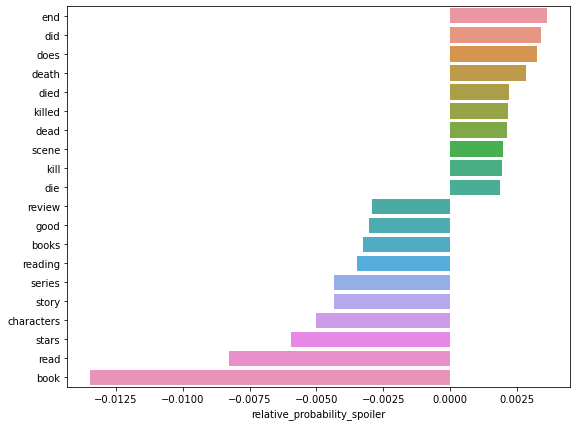

In [770]:
# same as above but TFIDF vectorizer
important_features_MB(sentences, labels,vectorizer = 'T')

### Word importance after lemmatization

In [699]:
# lemmatize input sentences
sentences_l = [lemmatizer(sen) for sen in sentences]

In [755]:
#write lemmatized sentences to file as this took forever
with open('lemmatized_spoiler_review_sentences.txt', 'w+') as new_file:
    for sen in sentences_l:
        new_file.write(f'{sen}\n')
new_file.close()

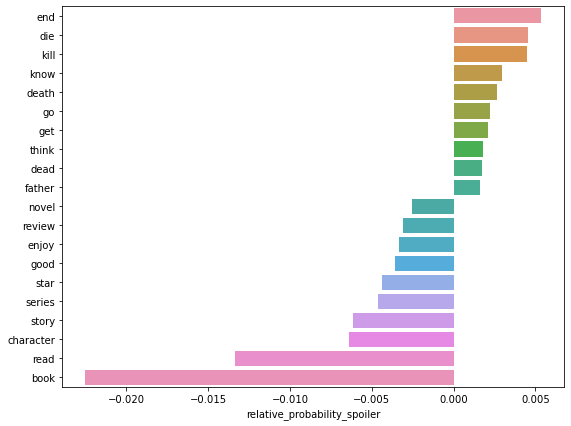

In [768]:
# word importance after lemmatization using Countvectorizer
important_features_MB(sentences_l, labels,vectorizer = 'C', stop_words = None)

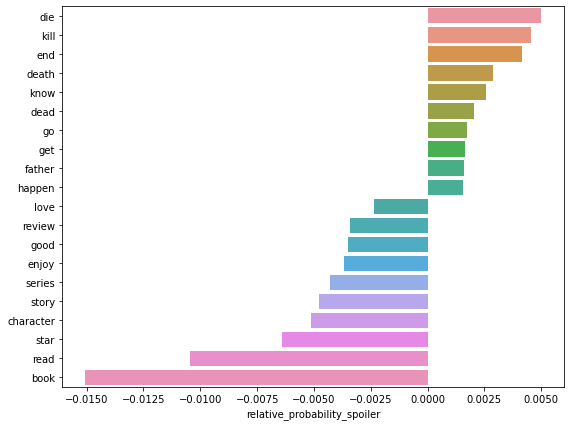

In [767]:
# test with TF-IDF
important_features_MB(sentences_l, labels,vectorizer = 'T', stop_words = None)

#### Word importance of linked words

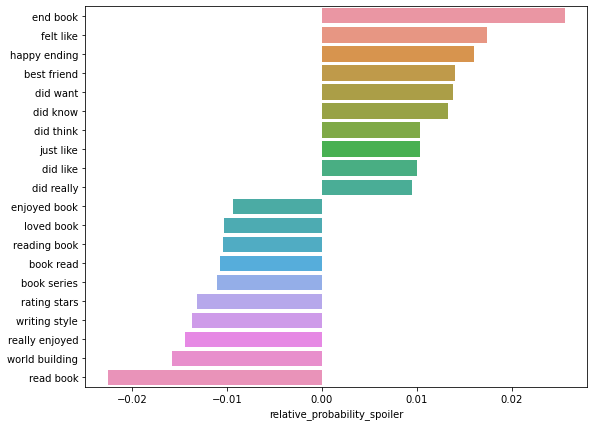

In [771]:
#calculate feature importance for bigrams (ngram = (2,2))
#use spellchecked sentences as input
important_features_MB(sentences, labels,vectorizer = 'C', stop_words = 'english', ngram = (2,2))

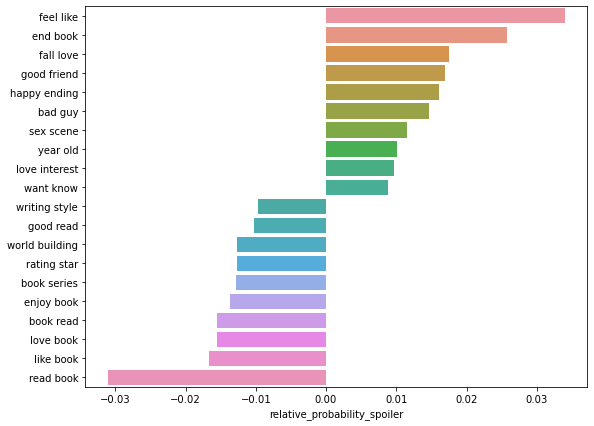

In [773]:
#calculate feature importance for bigrams (ngram = (2,2))
#use lemmatized sentences woithout stopwords and TFIDF vectorizer
important_features_MB(sentences_l, labels,vectorizer = 'T', stop_words = None, ngram = (2,2))

This semes to make a lot of scence: Phrases like 'end book', 'happy ending', 'fall (in) love' are things we can envision as spoiling a book. On the other side, 'read book', 'writing style', 'book series' are general terms.

### Word importance comparing entire reviews
__spoiler reviews vs non-spoiler reviews__

In [683]:
reviews = safe_text + spoiler_text_all
labels_all = [0]*len(safe_text) + [0]*len(spoiler_text_all)

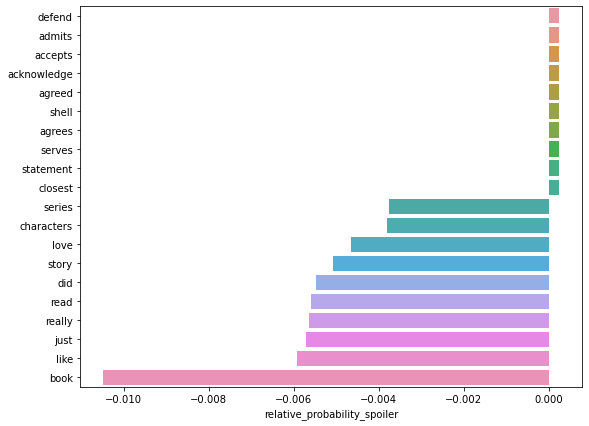

In [774]:
#importance of single words
important_features_MB(reviews, labels_all,vectorizer = 'T', stop_words = 'english', ngram = (1,1))

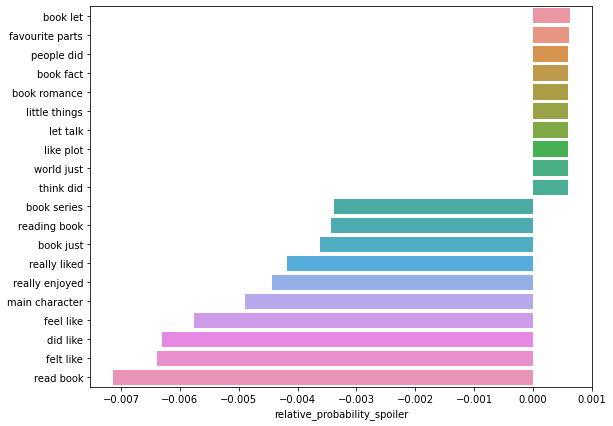

In [775]:
# importance of bigrams
important_features_MB(reviews, labels_all,vectorizer = 'T', stop_words = 'english', ngram = (2,2))

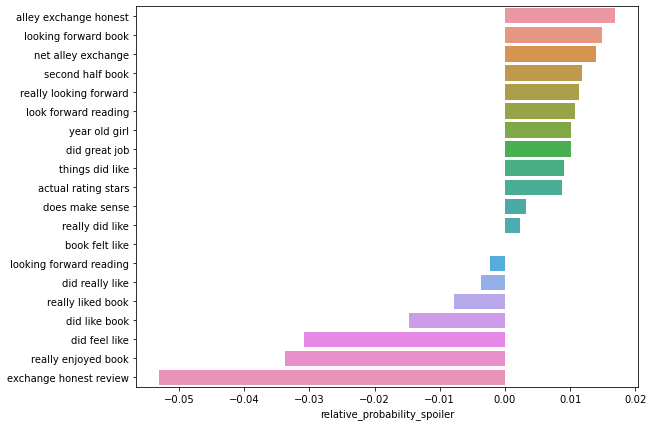

In [776]:
important_features_MB(reviews, labels_all,vectorizer = 'T', stop_words = 'english', ngram = (3,3))

In [777]:
# safe reviews ad labels, just in case
with open('reviews.txt', 'w+') as rw:
    json.dump(reviews, rw)

with open('review_labels.txt', 'w+') as rl:
    json.dump(labels_all, rl)
    
# to open:
#with open('reviews.txt', 'w+') as rw:
#    reviews = json.load(rw)

In [ ]:
t0 = time.time()
reviews_l = [lemmatizer(r) for r in reviews]
elapsed_time = time.time()-t0
time.strftime("%H:%M:%S", time.gmtime(elapsed_time))

In [622]:
import re
import nltk
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer 

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

stopset = nltk.corpus.stopwords.words('english') 
lemmatizer_wordnet = WordNetLemmatizer() 


def preprocessing1(text):
    # convert to lower, remove new lines, tabs and two spaces
    text = text.lower()
    #remove any whitespace characters including \n,..
    text = re.sub(r"\s+", ' ', text).strip()
    #remove urls
    text = re.sub('http://\S+|https://\S+', '', text)
    #remove punctation
    text = text.translate(str.maketrans('', '', punctuation))
    # remove stopwords
    text = " ".join([lemmatizer.lemmatize(i) for i in word_tokenize(text) if i not in stopset])
    #remove non-ascii characters
    text = unidecode(text)
    return text

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/gregor/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/gregor/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/gregor/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [251]:
print("   this is    a  test \n for sub of \t whitspaces")
re.sub(r"\s+", ' ', "   this is    a  test \n for sub of \t whitspaces").strip()

   this is    a  test 
 for sub of 	 whitspaces


'this is a test for sub of whitspaces'

In [30]:
import spacy
nlp_spacy_spacy = spacy.load("en_core_web_sm")

def preprocessing_spacy(text):
    text = text.lower()
    #remove URLS
    text = re.sub('http://\S+|https://\S+', '', text)
    # remove whitespaces, new line characters,..
    text = re.sub(r"\s+", ' ', text).strip()
    doc = nlp_spacy(text)
    text = " ".join([token.lemma_ for token in doc if not token.is_punct if not token.is_stop])
    return text

SyntaxError: invalid syntax (<ipython-input-30-96e495f24e9f>, line 1)

In [271]:
spacy_stopwords = nlp_spacy.Defaults.stop_words
'test' in spacy_stopwords

False

In [263]:
test  = "Test this, he's not!"
doc = nlp_spacy(test)
for word in doc:
    if  word.is_punct:
        print(word, '\t', word.lemma_, '\t', word.is_punct )

, 	 , 	 True
! 	 ! 	 True


In [301]:
text = ("this  is a test gregor.")
text = re.sub(r"\s+", ' ', text).strip()
text = re.sub('http://\S+|https://\S+', '', text)
doc = nlp_spacy(text)
" ".join([token.lemma_ for token in doc if not token.is_punct if not token.is_stop])

'test gregor'

In [2]:
token = 'this'
token = nlp_spacy(token)
for t in token:
    print(t.is_stop)

NameError: name 'nlp_spacy' is not defined

In [43]:
preprocessing_spacy("this  is a test gregor.")

'test gregor'

In [ ]:
sentences_wc_processed = [preprocessing1(sen) for sen in tqdm(sentences_wc)]

In [133]:
df_spoiler_text = pd.DataFrame({
    'sentences': sentences_wc,
    'sentences_processed':sentences_wc_processed,
    'labels':labels
    
})

In [157]:
#text_no_spoiler = " ".join(list(df_spoiler_text.sentences_processed[df_spoiler_text.labels  == 0]))
text_spoiler = " ".join(df_spoiler_text.sentences_processed[df_spoiler_text.labels  == 1])

In [161]:
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white")

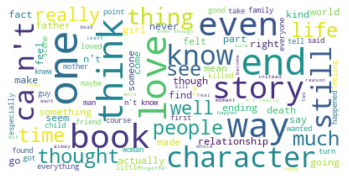

In [162]:
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white")
wordcloud_s = wordcloud.generate(text_spoiler)
plt.imshow(wordcloud_s, interpolation='bilinear')
plt.axis("off")
plt.show()